In [83]:
import pandas as pd
import networkx as nx
import backboning as bb  # assuming backboning.py is in your PYTHONPATH
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.express as px


### MAKING BACKBONE

In [84]:

import pandas as pd
import networkx as nx
import backboning as bb  # assuming backboning.py is in your PYTHONPATH

def nc_backbone_from_nx(G, weight_attr="weight", threshold=2.0, calculate_p_value=False):
    """
    Compute Noise-Corrected backbone from an undirected NetworkX graph.

    Args:
        G (nx.Graph): Undirected weighted graph.
        weight_attr (str): Edge attribute name for weights.
        threshold (float): Threshold for backbone extraction.
        calculate_p_value (bool): If True, compute p-values instead of NC score.

    Returns:
        backbone_edges (pd.DataFrame): DataFrame with columns [src, trg, nij, score].
    """
    # 1. Convert NetworkX graph to DataFrame
    edges = []
    for u, v, data in G.edges(data=True):
        w = data.get(weight_attr, 1.0)  # default weight = 1 if missing
        edges.append({"src": u, "trg": v, "weight": w})
    df = pd.DataFrame(edges)

    # 2. Compute NC backbone
    nc_table = bb.noise_corrected(
        df.rename(columns={"weight": "nij"}),  # rename for compatibility
        undirected=True,
        return_self_loops=False,
        calculate_p_value=calculate_p_value
    )

    # 3. Apply thresholding
    backbone = bb.thresholding(nc_table, threshold)

    return backbone

# Example usage:
# G = nx.read_weighted_edgelist("mygraph.edgelist")  # or any nx.Graph
# backbone_df = nc_backbone_from_nx(G, weight_attr="weight", threshold=2.0)
# print(backbone_df.head())


In [85]:
# import original graph
path = Path(r"/Users/iben/Desktop/Social_graphs/SocialGraphs/Project/MUSIC/artist_network.graphml")

G_lyrics = nx.read_graphml(path)

# number of nodes and edges
print(f"Original graph has {G_lyrics.number_of_nodes()} nodes and {G_lyrics.number_of_edges()} edges.")


Original graph has 1015 nodes and 63840 edges.


In [ ]:
# create NC backbone
NC_backbone_3 = nc_backbone_from_nx(G_lyrics, weight_attr="weight", threshold=3.0, calculate_p_value=False)
NC_backbone_2 = nc_backbone_from_nx(G_lyrics, weight_attr="weight", threshold=2.0, calculate_p_value=False)
NC_backbone_1 = nc_backbone_from_nx(G_lyrics, weight_attr="weight", threshold=1.0, calculate_p_value=False)


Calculating NC score...


In [ ]:
# number of nodes and edges in NC backbone 3
print(f"NC Backbone has {NC_backbone_3.shape[0]} edges.")

NC Backbone has 16333 edges.


In [ ]:
print(NC_backbone_3)

                    src                  trg  nij     score
13        Missy_Elliott                Ne-Yo    1  0.809201
14        Missy_Elliott        Nelly_Furtado    3  0.979738
15        Missy_Elliott              Omarion    1  0.971056
16        Missy_Elliott              OutKast    2  0.959456
17        Missy_Elliott               Shaggy    2  0.978867
...                 ...                  ...  ...       ...
63832           Bayside   I_Am_The_Avalanche    1  0.999865
63833          Quintino               Tujamo    1  0.999713
63836       Jagged_Edge             Makaveli    1  0.999155
63838  Claudelle_Clarke  The_Grace_Thrillers    1  0.999949
63839          Makaveli            Thug_Life    1  0.999916

[16333 rows x 4 columns]


In [ ]:
# make a networkx graph from the backbone dataframe
G_NC_backbone_3 = nx.from_pandas_edgelist(NC_backbone_3, source='src', target='trg', edge_attr='nij')
print(G_NC_backbone_3)
G_NC_backbone_2 = nx.from_pandas_edgelist(NC_backbone_2, source='src', target='trg', edge_attr='nij')
G_NC_backbone_1 = nx.from_pandas_edgelist(NC_backbone_1, source='src', target='trg', edge_attr='nij')

# add attributes on nodes and edges from original graph to backbone
for u, v, data in G_NC_backbone_3.edges(data=True):
    if G_lyrics.has_edge(u, v):
        for attr, value in G_lyrics[u][v].items():
            G_NC_backbone_3[u][v][attr] = value

for n, data in G_NC_backbone_3.nodes(data=True):
    if n in G_lyrics.nodes:
        for attr, value in G_lyrics.nodes[n].items():
            G_NC_backbone_3.nodes[n][attr] = value

# print number of nodes and edges in the backbone graph
print(f"NC Backbone Graph has {G_NC_backbone_3.number_of_nodes()} nodes and {G_NC_backbone_3.number_of_edges()} edges.")            

Graph with 1004 nodes and 16333 edges
NC Backbone Graph has 1004 nodes and 16333 edges.


In [ ]:

# top 10 artists by degree in NC backbone
degree_dict = dict(G_NC_backbone_3.degree())
top_10_artists = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]
print(top_10_artists)

# top 10 weighted edges in NC backbone
weighted_edges = nx.get_edge_attributes(G_NC_backbone_3, 'nij')
top_10_weighted_edges = sorted(weighted_edges.items(), key=lambda x: x[1], reverse=True)[:10]
print(top_10_weighted_edges)

# top 10 artisits by degree in original graph
degree_dict_original = dict(G_lyrics.degree())
top_10_artists_original = sorted(degree_dict_original.items(), key=lambda x: x[1], reverse=True)[:10]
print(top_10_artists_original)

# top 10 weighted edges in original graph
weighted_edges_original = nx.get_edge_attributes(G_lyrics, 'weight')
top_10_weighted_edges_original = sorted(weighted_edges_original.items(), key=lambda x: x[1], reverse=True)[:10]
print(top_10_weighted_edges_original)

# degree of top 10 artists from original graph in original graph vs NC backbone
for artist, _ in top_10_artists_original:
    degree_original = degree_dict_original.get(artist, 0)
    degree_backbone = degree_dict.get(artist, 0)
    print(f"Artist: {artist}, Degree in Original: {degree_original}, Degree in NC Backbone: {degree_backbone}")
# degree of top 10 artists from NC backbone in original graph vs NC backbone
for artist, _ in top_10_artists:
    degree_original = degree_dict_original.get(artist, 0)
    degree_backbone = degree_dict.get(artist, 0)
    print(f"Artist: {artist}, Degree in Original: {degree_original}, Degree in NC Backbone: {degree_backbone}")

[('Yeah_Yeah_Yeahs', 92), ('David_Bowie', 83), ('Billy_Joel', 81), ('Lana_Del_Rey', 80), ('A_R_I_Z_O_N_A', 79), ('Aerosmith', 79), ('Coldplay', 78), ('The_Shins', 78), ('The_xx', 77), ('Eagles', 77)]
[(('Drake', 'The_Weeknd'), 47), (('Drake', 'Kanye_West'), 45), (('Rihanna', 'The_Weeknd'), 35), (('Drake', 'Kendrick_Lamar'), 34), (('Drake', 'Future'), 31), (('Rae_Sremmurd', 'Big_Sean'), 30), (('Drake', 'Rae_Sremmurd'), 29), (('Rihanna', 'Chris_Brown'), 28), (('Chris_Brown', 'Drake'), 28), (('Major_Lazer', 'The_Chainsmokers'), 28)]
[('Rihanna', 587), ('The_Weeknd', 537), ('Ed_Sheeran', 531), ('Drake', 531), ('Coldplay', 511), ('Maroon_5', 502), ('Kanye_West', 493), ('Imagine_Dragons', 482), ('Calvin_Harris', 468), ('Ariana_Grande', 449)]
[(('Drake', 'The_Weeknd'), 47), (('Drake', 'Kanye_West'), 45), (('Rihanna', 'Drake'), 41), (('Drake', 'Big_Sean'), 39), (('Rihanna', 'The_Weeknd'), 35), (('Drake', 'Kendrick_Lamar'), 34), (('Rihanna', 'Kanye_West'), 33), (('Lil_Wayne', 'Drake'), 31), (('

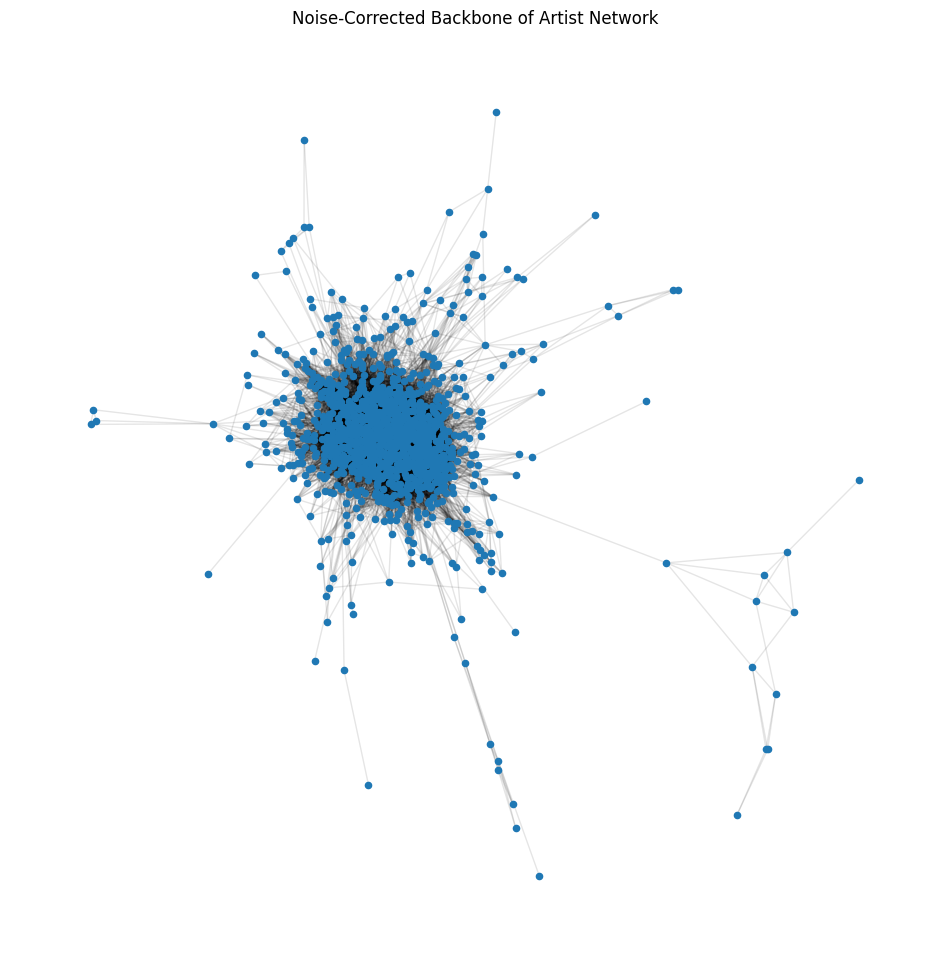

In [ ]:
# plot NC backbone
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_NC_backbone_3, k=0.1)  # positions for all nodes
nx.draw_networkx_nodes(G_NC_backbone_3, pos, node_size=20)
nx.draw_networkx_edges(G_NC_backbone_3, pos, alpha=0.1)
plt.title("Noise-Corrected Backbone of Artist Network")
plt.axis('off')
plt.show()

---
### THRESHOLD VS EDGES 
---

In [92]:
def plot_nc_backbone_thresholds(G, weight_attr="weight", thresholds=None):
    if thresholds is None:
        thresholds = [0.5, 1, 1.5, 2, 2.5, 3]

    # Convert NetworkX graph to DataFrame
    edges = [{"src": u, "trg": v, "nij": data.get(weight_attr, 1.0)}
             for u, v, data in G.edges(data=True)]
    df = pd.DataFrame(edges)

    # Compute NC scores
    nc_table = bb.noise_corrected(df, undirected=True, return_self_loops=False)

    # Calculate edge counts for each threshold
    edge_counts = []
    for t in thresholds:
        backbone = bb.thresholding(nc_table, t)
        edge_counts.append(len(backbone))

    # Plot using Plotly
    fig = px.line(x=thresholds, y=edge_counts, markers=True,
                  labels={'x': 'Threshold', 'y': 'Number of Edges'},
                  title='NC Backbone Edge Count vs Threshold')
    fig.show()

    return thresholds, edge_counts

# Example usage:
plot_nc_backbone_thresholds(G_lyrics, weight_attr="weight")


Calculating NC score...


([0.5, 1, 1.5, 2, 2.5, 3], [26121, 23511, 21245, 19368, 17743, 16333])

---
### Disparity filter
---


In [93]:
# Disparity Filter method, using edge weights.
def disparity_filter(G, alpha=0.05, weight='weight'):
    backbone = nx.Graph()
    for node in G.nodes():
        k = G.degree(node)
        if k > 1:
            sum_w = sum([G[node][nbr][weight] for nbr in G.neighbors(node)]) # sum of weights
            for nbr in G.neighbors(node):
                p_ij = G[node][nbr][weight] / sum_w # proportion of weight
                alpha_ij = (1 - p_ij) ** (k - 1) # significance level
                if alpha_ij < alpha: 
                    backbone.add_edge(node, nbr, weight=G[node][nbr][weight])
                    # add all atributes of the node and edge to the backbone
                    for attr, value in G.nodes[node].items():
                        backbone.nodes[node][attr] = value
                    for attr, value in G.nodes[nbr].items():
                        backbone.nodes[nbr][attr] = value
                    for attr, value in G[nbr][node].items():
                        backbone[nbr][node][attr] = value
    return backbone

In [94]:
# disparity backbone
DF_backbone = disparity_filter(G_lyrics, alpha=0.05, weight='weight')

# get gcc of DF backbone
DF_gcc = max(nx.connected_components(DF_backbone), key=len)
DF_backbone = DF_backbone.subgraph(DF_gcc).copy()

In [95]:
# number of nodes and edges in DF backbone
print(f"Disparity Filter Backbone has {DF_backbone.number_of_nodes()} nodes and {DF_backbone.number_of_edges()} edges.")

Disparity Filter Backbone has 448 nodes and 2432 edges.


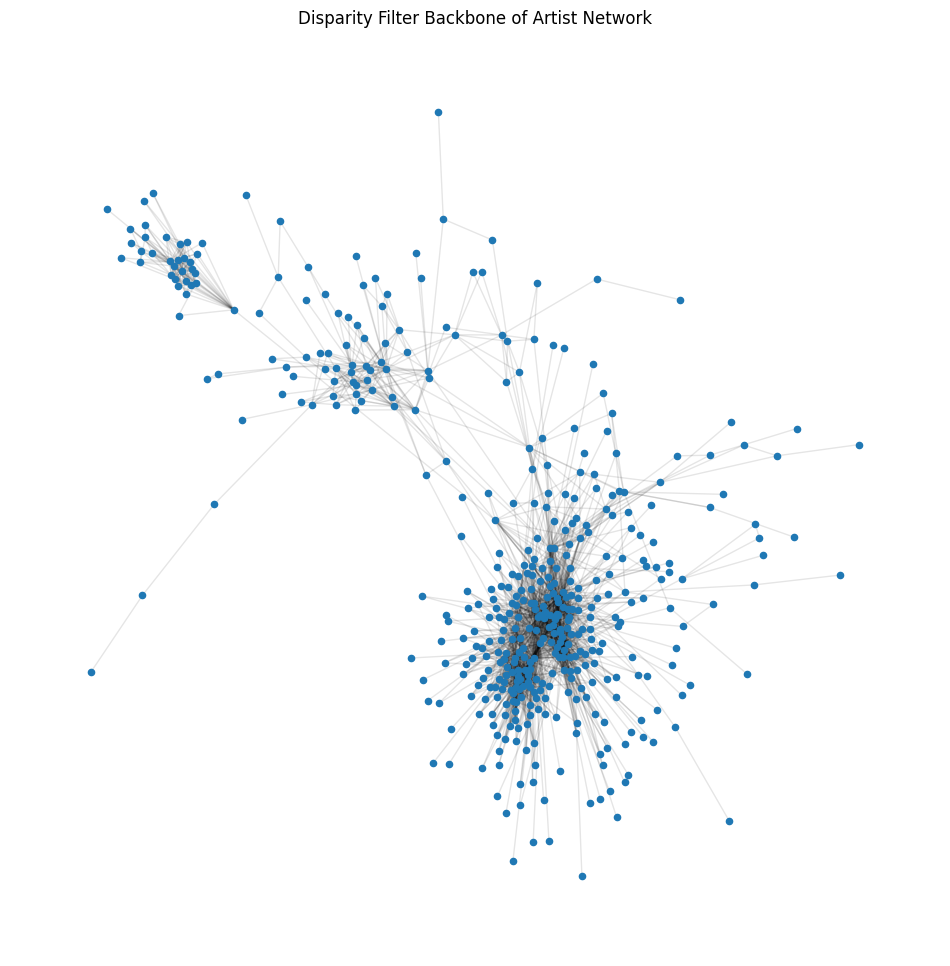

In [96]:
# plot DF backbone
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(DF_backbone, k=0.1)  # positions
nx.draw_networkx_nodes(DF_backbone, pos, node_size=20)
nx.draw_networkx_edges(DF_backbone, pos, alpha=0.1)
plt.title("Disparity Filter Backbone of Artist Network")
plt.axis('off')
plt.show()

---
### DEGREE DIST: FOR ORG AND BACKBONE
---

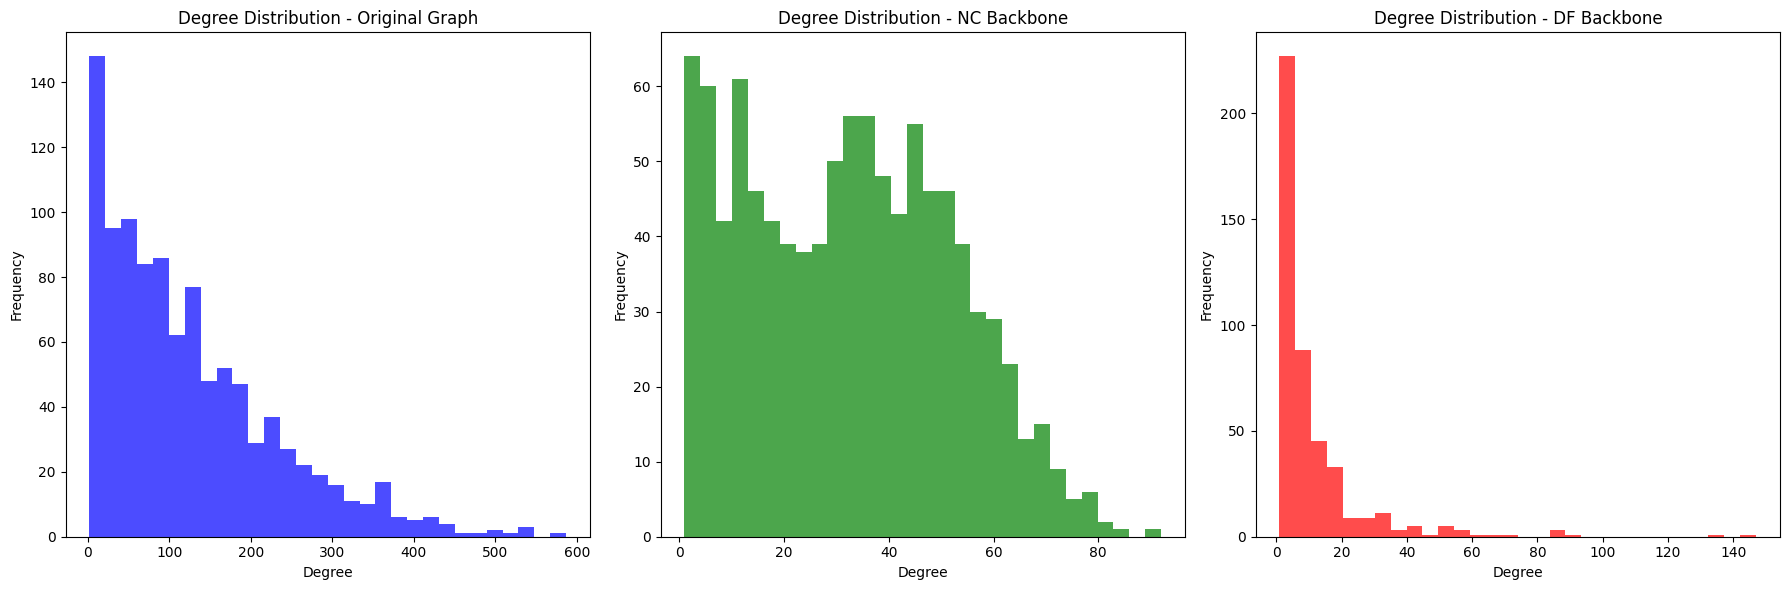

In [ ]:
# Degree dis.t of original graph vs NC backbone vs DF backbone in one figure with 3 subplots
def plot_degree_distributions(G_original, G_NC_backbone_3, G_DF_backbone):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Original graph
    degrees_original = [d for n, d in G_original.degree()]
    axes[0].hist(degrees_original, bins=30, color='blue', alpha=0.7)
    axes[0].set_title('Degree Distribution - Original Graph')
    axes[0].set_xlabel('Degree')
    axes[0].set_ylabel('Frequency')

    # NC Backbone
    degrees_nc = [d for n, d in G_NC_backbone_3.degree()]
    axes[1].hist(degrees_nc, bins=30, color='green', alpha=0.7)
    axes[1].set_title('Degree Distribution - NC Backbone')
    axes[1].set_xlabel('Degree')
    axes[1].set_ylabel('Frequency')

    # DF Backbone
    degrees_df = [d for n, d in G_DF_backbone.degree()]
    axes[2].hist(degrees_df, bins=30, color='red', alpha=0.7)
    axes[2].set_title('Degree Distribution - DF Backbone')
    axes[2].set_xlabel('Degree')
    axes[2].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

plot_degree_distributions(G_lyrics, G_NC_backbone_3, DF_backbone)

In [ ]:
# Save Graph in GraphML format (lists/dicts are JSON-strings)
nx.write_graphml(G_NC_backbone_3, "/Users/iben/Desktop/Social_graphs/SocialGraphs/Project/MUSIC/artist_network_backbone.graphml")

In [ ]:
# what atributes does the backbone have
print("Node attributes in NC Backbone:", list(G_NC_backbone_3.nodes(data=True))[0][1].keys())
print("Edge attributes in NC Backbone:", list(G_NC_backbone_3.edges(data=True))[0][2].keys())

Node attributes in NC Backbone: dict_keys(['songs', 'albums', 'playlists', 'num_playlists', 'num_songs', 'avg_song_duration', 'lyrics'])
Edge attributes in NC Backbone: dict_keys(['nij', 'shared_playlists', 'weight', 'co_occurrence_count'])


In [ ]:
# lyrics of a specific artist in the backbone
artist_name = "Adele"
if artist_name in G_NC_backbone_3.nodes:
    lyrics = G_NC_backbone_3.nodes[artist_name].get('lyrics', 'No lyrics attribute found.')
    print(f"Lyrics for {artist_name} in NC Backbone:\n{lyrics}")
    

Lyrics for Adele in NC Backbone:


Who wants to be right as rain?
It's better when something is wrong
You get excitement in your bones
And everything you do's a game
When night comes, and you're on your own
You can say, "I chose to be alone"
Who wants to be right as rain?
It's harder when you're on top

'Cause when hard work don't pay off and I'm tired
There ain't no room in my bed, as far as I'm concerned
So wipe that dirty smile off
We won't be making up, I've cried my heart out
And now I've had enough of love

Who wants to be riding high
When you'll just crumble back on down?
You give up everything you are
And even then, you don't get far
They make believe that everything
Is exactly what it seems
But at least when you're at your worst
You know how to feel things
You might also like
See, when hard work don't pay off and I'm tired
There ain't no room in my bed, as far as I'm concerned
So wipe that dirty smile off
We won't be making up, I've cried my heart out
And now, I've had enough 